In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml

In [2]:
#opens yaml file
try:
    with open("../config.yaml") as file:
        config = yaml.safe_load(file)
except:
    print("Sorry, configuration file not found!")

In [3]:
# Load the dataset from yaml file directory
#file_path = '../data/raw/Extended_Employee_Performance_and_Productivity_Data.csv'
#df = pd.read_csv(file_path)
df = pd.read_csv(config['input_data']['productivity_file'])

df

,Employee_ID,Department,Gender,Age,Job_Title,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
0,1,IT,Male,55,Specialist,2022-01-19 08:03:05.556036,2,High School,5,6750.0,33,32,22,2,0,14,66,0,2.63,False
1,2,Finance,Male,29,Developer,2024-04-18 08:03:05.556036,0,High School,5,7500.0,34,34,13,14,100,12,61,2,1.72,False
2,3,Finance,Male,55,Specialist,2015-10-26 08:03:05.556036,8,High School,3,5850.0,37,27,6,3,50,10,1,0,3.17,False
3,4,Customer Support,Female,48,Analyst,2016-10-22 08:03:05.556036,7,Bachelor,2,4800.0,52,10,28,12,100,10,0,1,1.86,False
4,5,Engineering,Female,36,Analyst,2021-07-23 08:03:05.556036,3,Bachelor,2,4800.0,38,11,29,13,100,15,9,1,1.25,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,Finance,Male,27,Technician,2022-12-07 08:03:05.556036,1,Bachelor,4,4900.0,55,46,5,3,75,16,48,2,1.28,False
99996,99997,IT,Female,36,Consultant,2018-07-24 08:03:05.556036,6,Master,5,8250.0,39,35,7,0,0,10,77,1,3.48,True
99997,99998,Operations,Male,53,Analyst,2015-11-24 08:03:05.556036,8,High School,2,4800.0,31,13,6,5,0,5,87,1,2.60,False
99998,99999,HR,Female,22,Consultant,2015-08-03 08:03:05.556036,9,High School,5,8250.0,35,43,10,1,75,2,31,1,3.10,False


In [4]:
def cleaning_productivity_data(df):
    """
    Cleans the Extended_Employee_Performance_and_Productivity_Data.csv DataFrame by 
    performing multiple data preparation steps, including
    dropping unnecessary columns, filtering rows, normalizing numeric values, and renaming
    columns. This function also categorizes work types for easier analysis.

    Parameters:
    df (pandas.DataFrame): The input dataset to clean. Expected to contain columns such as 
    'Employee_ID', 'Hire_Date', 'Team_Size', 'Department', 'Remote_Work_Frequency', 
    'Promotions', 'Training_Hours', 'Employee_Satisfaction_Score', and 'Performance_Score'.

    Returns:
    pandas.DataFrame(df_cleaned): The cleaned dataset with the following transformations:
        - Columns 'Employee_ID', 'Hire_Date', and 'Team_Size' are dropped.
        - Rows are filtered to include only 'IT' department and exclude certain 'Remote_Work_Frequency' values (75 and 25).
        - 'Remote_Work_Frequency' values are replaced with labels ('Remote', 'Hybrid', 'Onsite') and renamed to 'work_type'.
        - 'Promotions' and 'Training_Hours' columns are normalized to a 1-5 scale, and a 'Motivation_Score' is calculated as the average of four factors.
        - Column names are standardized to lowercase, and work types are set as an ordered categorical variable.

    Raises:
    KeyError: If any of the required columns ('Department', 'Remote_Work_Frequency', etc.) are missing.
    ValueError: If unexpected data types are encountered in columns used for numeric calculations 
                (e.g., non-numeric values in 'Promotions' or 'Training_Hours').

    Examples:
    >>> import pandas as pd
    >>> # Load a sample dataset
    >>> df = pd.read_csv("employee_data.csv")
    >>> # Apply the cleaning function
    >>> df_cleaned = cleaning(df)
    >>> # View the cleaned DataFrame
    >>> print(df_cleaned.head())

    Notes:
    - The function filters only for rows in the 'IT' department and excludes 'Remote_Work_Frequency' values of 25 and 75.
    - Converts 'Remote_Work_Frequency' values into readable labels ('Remote', 'Hybrid', 'Onsite') and renames the column to 'work_type'.
    - Adds a 'Motivation_Score' column as the average of normalized 'Employee_Satisfaction_Score', 'Performance_Score', 'Promotions', and 'Training_Hours' on a 1-5 scale.
    - Column names are converted to lowercase, and 'work_type' is set as an ordered categorical variable.
    """
    
    # Drop unnecessary columns, columns_to_drop = ['Employee_ID', 'Hire_Date', 'Team_Size']
    df_cleaned = df.drop(columns=['Employee_ID', 'Hire_Date', 'Team_Size'], errors='ignore')

    # Filter for only IT department and Remote work Frequencies to a more managable, 100, 50, 0
    df_cleaned = df_cleaned[(df_cleaned['Department'] == 'IT') & 
                (df_cleaned['Remote_Work_Frequency'] != 75) & 
                (df_cleaned['Remote_Work_Frequency'] != 25)].copy()

    # Replace Remote_Work_Frequency values with readable labels
    df_cleaned['Remote_Work_Frequency'] = df_cleaned['Remote_Work_Frequency'].replace({
        100: 'Remote',
        50: 'Hybrid',
        0: 'Onsite'
    })

    # Normalize 'Promotions' and 'Training Hours' to a 1-5 range to create a Motivations Score
    df_cleaned['Promotions_Normalized'] = (df_cleaned['Promotions'] / df_cleaned['Promotions'].max()) * 4 + 1
    df_cleaned['Training_Hours_Normalized'] = (df_cleaned['Training_Hours'] / df_cleaned['Training_Hours'].max()) * 4 + 1

    # Calculate the Motivation Score within a 1-5 range
    df_cleaned['Motivation_Score'] = (
    df_cleaned['Employee_Satisfaction_Score'] +
    df_cleaned['Performance_Score'] +
    df_cleaned['Promotions_Normalized'] +
    df_cleaned['Training_Hours_Normalized']
    ) / 4  # Averaging the four factors

    # Round the Motivation Score to 2 decimal places
    df_cleaned['Motivation_Score'] = df_cleaned['Motivation_Score'].round(2)

    # Drop the temporary normalization columns
    df_cleaned = df_cleaned.drop(columns=['Promotions_Normalized', 'Training_Hours_Normalized']).reset_index(drop=True)

    # Change column names to lowercase
    df_cleaned.columns = df_cleaned.columns.str.lower()

    # Rename 'remote_work_frequency' to 'work_type'
    df_cleaned = df_cleaned.rename(columns={'remote_work_frequency': 'work_type'})

    # Set the order of work_type categories
    df_cleaned['work_type'] = pd.Categorical(
    df_cleaned['work_type'],
    categories=['Remote', 'Hybrid', 'Onsite'],
    ordered=True
    )
    #display all columns
    pd.set_option('display.max_columns', None)
    print(df_cleaned.head())
    
    return df_cleaned


In [5]:
df_cleaned = cleaning_productivity_data(df)

  department  gender  age   job_title  years_at_company education_level  \
0         IT    Male   55  Specialist                 2     High School   
1         IT    Male   43     Manager                 8     High School   
2         IT    Male   37  Technician                 1        Bachelor   
3         IT    Male   48  Specialist                 2        Bachelor   
4         IT  Female   42   Developer                 1     High School   

   performance_score  monthly_salary  work_hours_per_week  projects_handled  \
0                  5          6750.0                   33                32   
1                  3          7800.0                   46                31   
2                  5          5250.0                   55                20   
3                  1          4950.0                   46                 7   
4                  1          5500.0                   53                20   

   overtime_hours  sick_days work_type  training_hours  promotions  \
0   

In [42]:
#output_file_path = '../data/clean/df_cleaned.csv'
#df_cleaned.to_csv(output_file_path, index=False)
df_cleaned.to_csv(config['output_data']['productivity_file'], index=False)

In [7]:
def describe_work_type_stats(df_cleaned, column_name='work_type', work_types=['Remote', 'Hybrid', 'Onsite']):   
    """
    Filters the DataFrame for specified work type values, groups by the work type column, 
    and calculates descriptive statistics for each group. The function displays all columns 
    in the output for easier analysis.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data to analyze.
    column_name (str): The name of the column to filter and group by. Default is 'work_type'.
    work_types (list): A list of work type values to filter for (e.g., ['Remote', 'Hybrid', 'Onsite']).

    Returns:
    pandas.DataFrame: A DataFrame with descriptive statistics for each specified work type.

    Raises:
    KeyError: If the specified column name does not exist in the DataFrame.
    TypeError: If the input DataFrame is not a pandas DataFrame or if `column_name` is not a string.
    ValueError: If `work_types` is not a list.

    Notes:
    - The function uses `pd.set_option('display.max_columns', None)` to display all columns 
      in the output, making it easier to view all descriptive statistics.
    - The `observed=True` parameter in `groupby` limits grouping to observed categories only,
      which improves performance and aligns with future behavior in pandas.

    Examples:
    >>> import pandas as pd
    >>> # Assume df_cleaned is a DataFrame with a 'work_type' column
    >>> describe_stats = describe_work_type_stats(df_cleaned)
    >>> print(describe_stats)
    """
    
    # Filter data for specified work types
    filtered_df = df_cleaned[df_cleaned[column_name].isin(work_types)]

    # Group by work type and calculate descriptive statistics
    describe_stats = filtered_df.groupby(column_name, observed=True).describe()

    # Set display option to show all columns
    pd.set_option('display.max_columns', None)

    print(describe_stats)

    return describe_stats

In [8]:
describe_stats = describe_work_type_stats(df_cleaned)


              age                                                       \
            count       mean        std   min    25%   50%   75%   max   
work_type                                                                
Remote     2178.0  40.898531  11.424908  22.0  30.25  41.0  51.0  60.0   
Hybrid     2263.0  40.625276  11.406953  22.0  31.00  40.0  50.0  60.0   
Onsite     2214.0  41.454381  11.050901  22.0  32.00  41.0  51.0  60.0   

          years_at_company                                                \
                     count      mean       std  min  25%  50%  75%   max   
work_type                                                                  
Remote              2178.0  4.482553  2.910378  0.0  2.0  5.0  7.0  10.0   
Hybrid              2263.0  4.380910  2.873678  0.0  2.0  4.0  7.0   9.0   
Onsite              2214.0  4.467480  2.864555  0.0  2.0  4.0  7.0   9.0   

          performance_score                                               \
                      

In [9]:
'''
Interpretation of descriptive stats:
1)Age: mean age is very similar, between 40-41 years, the std is also similar aross the work types of 11 years. The interquartile range indicates employees fall between 30 to 50 years old which could suggest the data is based on more experienced IT professionals rather than junior or entry level.
2)Years at company: the average tenure across all work types ranges 4.38 - 4.48 years, the interquartile range is between 2 to 7 years, can be considered as relatively low turnover within the IT industry
3)Performance Score: The mean shows very similar variability across the work types with a very slight lower score for onsite workers. This can suggest that the work type doesn't impact employee productivity or performance.
4)Monthly salary: the mean salary is 6400 with similar ranges. This can be used to consider there is pay equality amongst the different work types.
5)Work hours per week: weekly average work hours are 45 across all groups which can indicate that the workloads are similar. We can assume all work types are just as productive.
6)Projects handled: are also very similar at 24 projects across all work types, this shows that the work type does not impact the employees to handle projects.
7)Overtime hours: we are asumming this is a monthly figure, the average is 14-15 hours across the work types with a wide spread of 0 to about 29 hours. Which can indicate a flexible work approach in the IT industry.
8)Sick days: the assumption is this is a yearly figure, the average number of sick days taken are 7. This can indicate that the work type does not influence health or attendance.
9)Training hours: shows an average of 48-50 across the work types with a high variablity from 0 to 99. We assume here that all work types have the same about of opportunity to training resources.
10)Promotions: are just under 1 across work types which might indicate that promotions are not frequent, however, with the remote work type having slightly less that 1 promotion might indicate less chance for promotion for remote workers.
11)Employee satisfaction score: the average score is approximately 3 out of 5 with the same std for all work types which indicate that work type does not impact job satisfaction.
12)Motivation score: average is around 3 out of 5 among all work types which suggests the different work environments have similar motivation
Conclusion:
Work type doesn’t show significant differences in productivity, satisfaction or motivation. We can infer if a company has a strong digital infrastructure and if they can provide equal access to resources, work environments do not matter.
'''

"\nInterpretation of descriptive stats:\n1)Age: mean age is very similar, between 40-41 years, the std is also similar aross the work types of 11 years. The interquartile range indicates employees fall between 30 to 50 years old which could suggest the data is based on more experienced IT professionals rather than junior or entry level.\n2)Years at company: the average tenure across all work types ranges 4.38 - 4.48 years, the interquartile range is between 2 to 7 years, can be considered as relatively low turnover within the IT industry\n3)Performance Score: The mean shows very similar variability across the work types with a very slight lower score for onsite workers. This can suggest that the work type doesn't impact employee productivity or performance.\n4)Monthly salary: the mean salary is 6400 with similar ranges. This can be used to consider there is pay equality amongst the different work types.\n5)Work hours per week: weekly average work hours are 45 across all groups which ca

In [40]:
def plot_work_type_distribution(df_cleaned, work_type):
    """
    Plots a donut chart showing the distribution in percentage of values of the work_type column.
    
    Parameters:
    df_cleaned(pandas.DataFrame): The DataFrame containing the data.
    work_type (str): The name of the column to analyze and plot.
    
    Returns:
    pandas.Series: The counts of each category in the specified column.

    Examples:
    counts = plot_work_type_distribution(df_cleaned, 'work_type')
    print(counts)

    Notes:
    The function saves the donut chart to the figures folder.
    
    """
    # Count the occurrences of each unique value in the specified column
    value_counts = df_cleaned['work_type'].value_counts()

    # Plot a donut chart
    plt.figure(figsize=(6, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3})
    plt.title(f"Distribution of {'Work Type'.capitalize()}")

    #saves figure
    plt.savefig("../figures/distribution_of_work_type.jpeg", format="jpeg", dpi=300)

    #displays figure
    plt.show()
    
    # Return the counts
    return value_counts

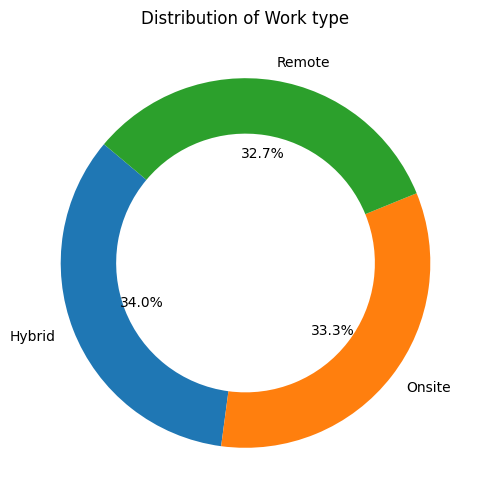

work_type
Hybrid    2263
Onsite    2214
Remote    2178
Name: count, dtype: int64

In [41]:
plot_work_type_distribution(df_cleaned, 'work_type')

In [12]:
avg_scores_by_work_type = df_cleaned.groupby('work_type', observed=True)[['performance_score', 'employee_satisfaction_score', 'motivation_score']].mean().round(2)
display(avg_scores_by_work_type)

,performance_score,employee_satisfaction_score,motivation_score
work_type,,,
Remote,3.00,3.02,3.00
Hybrid,3.01,3.00,3.00
Onsite,2.97,3.00,2.99


- Overall, work types do not have a significant effect on performance, employee satisfaction and motivation scores. The slightly higher employee satisfaction score actually supports a flexible work policy.

In [13]:
def plot_stacked_work_and_overtime_hours(df_cleaned):
    """
    Plots the average work hours and overtime hours by work type as a stacked bar chart.

    The function calculates the average 'work_hours_per_week' and 'overtime_hours' 
    grouped by 'work_type' and plots these values in a stacked bar chart.

    Parameters:
    - df_cleaned(pandas.DataFrame): The input DataFrame expected to contain 'work_type', 'work_hours_per_week', and 'overtime_hours' columns.

    Returns:
    - None: The function displays the plot in the Jupyter notebook output and 
            saves the figure as a JPEG file

    Example Usage:
    # Assume df_cleaned is a DataFrame with the necessary columns.
    plot_stacked_work_and_overtime_hours(df_cleaned)
    
    Notes:
    - The stacked chart shows total hours per work type with sections representing 
      regular work hours and overtime hours.
    """
    
    # Calculate the mean work hours and overtime hours by work type
    mean_hours = df_cleaned.groupby('work_type', observed=True)[['work_hours_per_week', 'overtime_hours']].mean()

    # Plot a stacked bar chart
    plt.figure(figsize=(10, 6))
    work_types = mean_hours.index
    work_hours = mean_hours['work_hours_per_week']
    overtime_hours = mean_hours['overtime_hours']
    
    # Create stacked bars
    plt.bar(work_types, work_hours, label='Work Hours', color='skyblue')
    plt.bar(work_types, overtime_hours, bottom=work_hours, label='Overtime Hours', color='salmon')
    
    # Add labels and title
    plt.title("Average Work and Overtime Hours by Work Type")
    plt.ylabel("Average Hours")
    plt.xlabel("Work Type")
    plt.legend()

    #saves chart as a jpeg
    plt.savefig("../figures/work_hours.jpeg", format="jpeg", dpi=300)

    # Show the plot
    plt.show()

    return mean_hours


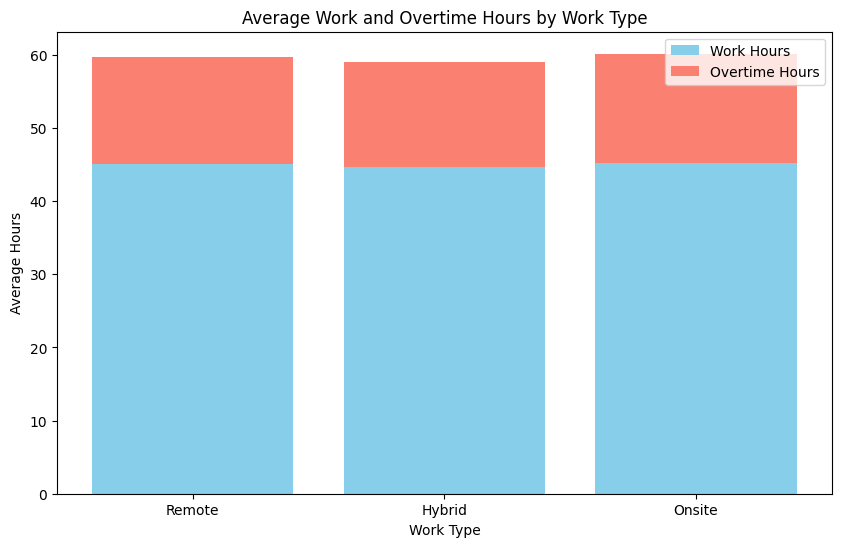

,work_hours_per_week,overtime_hours
work_type,,
Remote,45.012856,14.690083
Hybrid,44.632346,14.443659
Onsite,45.186089,14.962060


In [14]:
plot_stacked_work_and_overtime_hours(df_cleaned)

In [15]:
def calculate_avg_median_scores_by_work_type(df_cleaned):
    """
    Calculates the average (mean) and median scores for Performance, Motivation, 
    and Employee Satisfaction by work type.

    Parameters:
    - df_cleaned(pandas.DataFrame): The input DataFrame, expected to contain 'work_type', 'performance_score', 'motivation_score', and 
    'employee_satisfaction_score' columns. 
    
    Returns:
    - pandas.DataFrame: A pivot table showing the mean and median of each score type 
                        (Performance, Motivation, Satisfaction) by work type.

    Example Usage:
    >>> # Assume df_cleaned is a DataFrame with the necessary columns.
    >>> pivot_avg_scores = calculate_avg_median_scores_by_work_type(df_cleaned)
    >>> display(pivot_avg_scores)

    Notes:
    - The function creates a pivot table grouped by 'work_type', calculating both 
      mean and median values for 'performance_score', 'motivation_score', and 
      'employee_satisfaction_score'.
    """
    
    # Create the pivot table with mean and median for each score by work type
    pivot_avg_scores = df_cleaned.pivot_table(
        values=['performance_score', 'motivation_score', 'employee_satisfaction_score'],
        index='work_type',
        aggfunc=['mean', 'median'],
        observed=True
    )

    # Display the pivot table
    print(pivot_avg_scores)
    
    return pivot_avg_scores




In [16]:
pivot_avg_scores = calculate_avg_median_scores_by_work_type(df_cleaned)


                                 mean                                     \
          employee_satisfaction_score motivation_score performance_score   
work_type                                                                  
Remote                       3.023632         3.002365          3.004591   
Hybrid                       2.999973         3.002585          3.006186   
Onsite                       2.999846         2.989503          2.970641   

                               median                                     
          employee_satisfaction_score motivation_score performance_score  
work_type                                                                 
Remote                           3.07             3.03               3.0  
Hybrid                           2.97             3.00               3.0  
Onsite                           2.98             2.99               3.0  


- Overall, work types do not have a significant effect on performance, employee satisfaction and motivation scores. The slightly higher employee satisfaction and motivation scores actually supports a flexible work policy.

In [38]:
def plot_average_scores_by_work_type(df_cleaned, work_type):
    """
    Calculates and plots the average scores for specified metrics by work type.

    This function groups the data by work type, calculates the mean scores for the specified columns, 
    and generates a bar chart to visualize the average scores. The plot can optionally be saved to a specified path.

    Parameters:
    df_cleaned(pandas.DataFrame): The DataFrame containing the data.
    work_type_column (str): The name of the column representing work type (e.g., 'Remote', 'Hybrid', 'Onsite'). Default is 'work_type'.
    score_columns (list): A list of column names for the metrics to calculate average scores for (e.g., ['performance_score', 'employee_satisfaction_score', 'motivation_score']).

    Returns:
    mean_score 
    saves the file as a jpeg
    Displays a bar chart of average scores by work type.

    Example Usage:
    plot_average_scores_by_work_type(df_cleaned, 'work_type')
    display(mean_scores_melted)

     Notes:
    - This function requires Seaborn for the bar chart and Matplotlib for plotting and saving the image.
    """
    
    # Calculate mean scores by work type
    mean_scores = df_cleaned.groupby('work_type', observed=True)[['performance_score', 'employee_satisfaction_score', 'motivation_score']].mean().reset_index()

    # Melt the DataFrame for easier plotting
    mean_scores_melted = mean_scores.melt(id_vars='work_type', var_name='Score Type', value_name='Average_Score')

    # Plot a bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mean_scores_melted, x='Score Type', y='Average_Score', hue='work_type')
    plt.title("Average Scores of Performance, Satisfaction, and Motivation by Work Type")
    plt.ylabel("Average Score")
    plt.savefig("../figures/average_scores.jpeg", format="jpeg", dpi=300)
    plt.show()

    #display long format table
    display(mean_scores_melted)
    
    return mean_scores

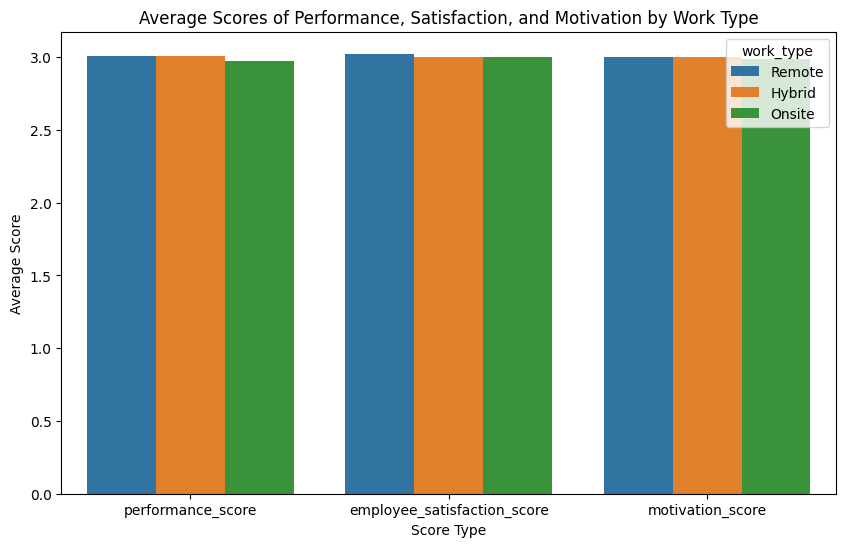

,work_type,Score Type,Average_Score
0,Remote,performance_score,3.004591
1,Hybrid,performance_score,3.006186
2,Onsite,performance_score,2.970641
3,Remote,employee_satisfaction_score,3.023632
4,Hybrid,employee_satisfaction_score,2.999973
5,Onsite,employee_satisfaction_score,2.999846
6,Remote,motivation_score,3.002365
7,Hybrid,motivation_score,3.002585
8,Onsite,motivation_score,2.989503


,work_type,performance_score,employee_satisfaction_score,motivation_score
0,Remote,3.004591,3.023632,3.002365
1,Hybrid,3.006186,2.999973,3.002585
2,Onsite,2.970641,2.999846,2.989503


In [39]:
plot_average_scores_by_work_type(df_cleaned, 'work_type')

In [36]:
def plot_scores_by_work_type(df_cleaned):
    """
    Creates box plots for Employee Satisfaction Score, Motivation Score, and Performance Score
    by work type.

    Parameters:
    - df_cleaned (pandas.DataFrame): The input DataFrame, expected to contain 'work_type', 'employee_satisfaction_score', 'motivation_score', 
    and 'performance_score' columns.
                             
    Returns:
    - None: The function displays the plot in the Jupyter notebook output and saves the figure as a JPEG file.

    Example Usage:
    >>> # Assume df_cleaned is a DataFrame with the necessary columns.
    >>> plot_scores_by_work_type(df_cleaned)
    
    Notes:
    - The function generates a box plot for each score type (Satisfaction, Motivation, Performance) 
      grouped by 'work_type' in a 1-row, 3-column layout.
    """
    
    # Set up the figure and individual box plots
    plt.figure(figsize=(14, 6))
    
    # Employee Satisfaction Score
    plt.subplot(1, 3, 1)
    sns.boxplot(x='work_type', y='employee_satisfaction_score', data=df_cleaned)
    plt.title('Employee Satisfaction Score by Work Type')

    # Motivation Score
    plt.subplot(1, 3, 2)
    sns.boxplot(x='work_type', y='motivation_score', data=df_cleaned)
    plt.title('Motivation Score by Work Type')

    # Performance Score
    plt.subplot(1, 3, 3)
    sns.boxplot(x='work_type', y='performance_score', data=df_cleaned)
    plt.title('Performance Score by Work Type')

    # Adjust layout for spacing
    plt.tight_layout()

    #save the plot
    plt.savefig("../figures/plot_scores.jpeg", format="jpeg", dpi=300)
    
    # Show the plot
    plt.show()

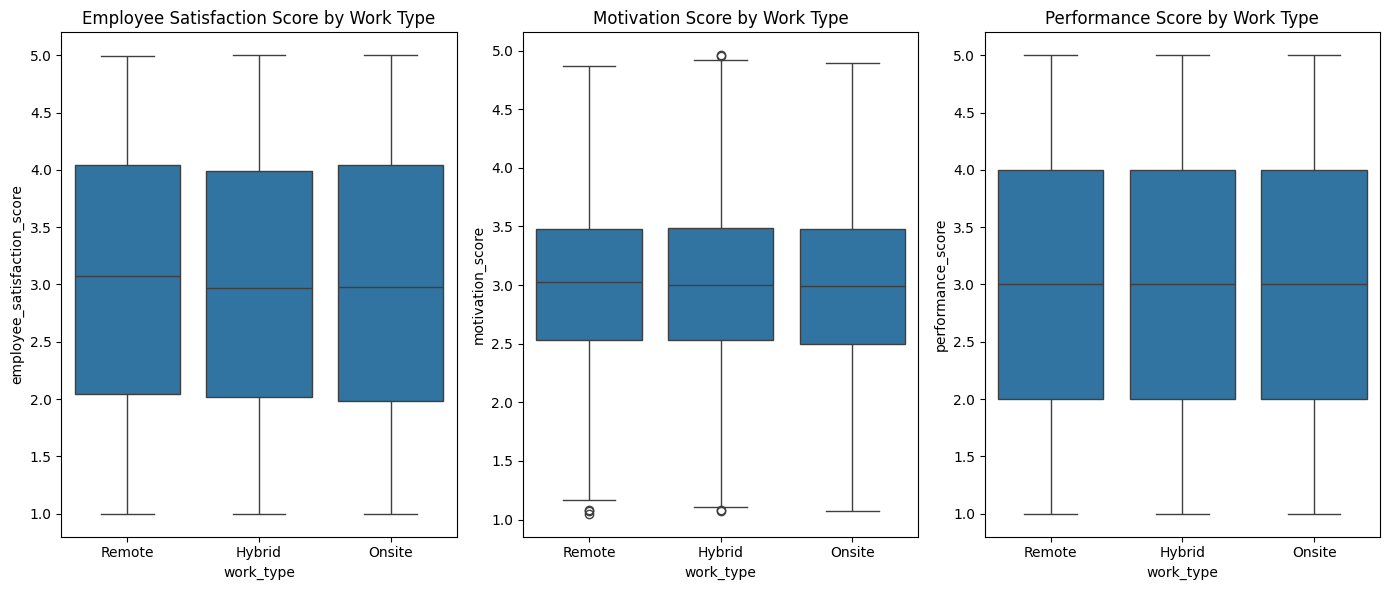

In [37]:
plot_scores_by_work_type(df_cleaned)

In [45]:
def heat_map(df_cleaned):
    """
    Plots a heatmap showing the correlation between numerical columns in the DataFrame.

    Parameters:
    df_cleaned (pandas.DataFrame): The DataFrame containing the data.

    Returns:
    pandas.DataFrame: The correlation matrix of the numerical columns.

    Examples:
    correlation_matrix = heat_map(df_cleaned)
    print(correlation_matrix)

    Notes:
    The function saves the heatmap to the figures folder.
    
    """
    numerical_df = df_cleaned.select_dtypes(include='number')

    # Calculate the correlation matrix for numerical columns
    correlation_matrix = numerical_df.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap of Numerical Values")

    #save the plot
    plt.savefig("../figures/heat_map.jpeg", format="jpeg", dpi=300)

    #display the plot
    plt.show()

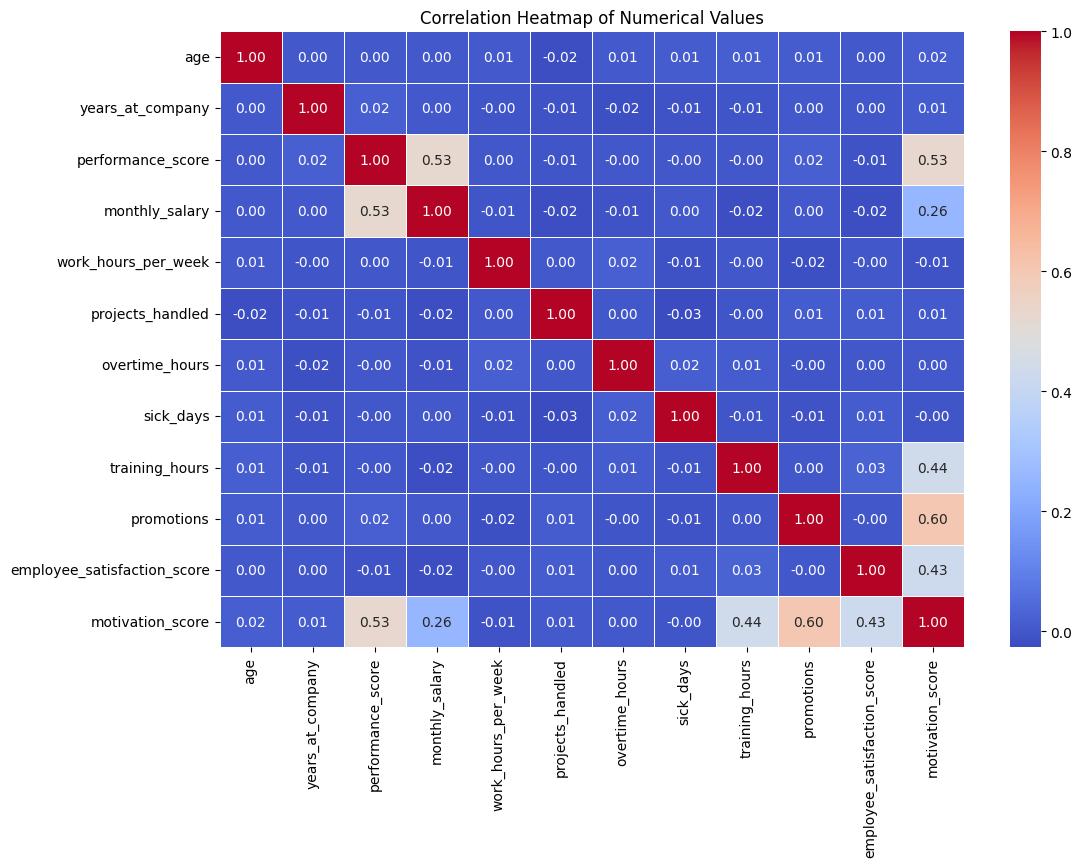

In [46]:
heat_map(df_cleaned)